In [35]:
#hide
from utils import *
hc(
    "Comparing Pitch Trackers",
    ["praat-parselmouth", "pyreaper","librosa", "pyworld"]
)
toc(
    [
        "References",
        "AIM",
        "Uncontrolled Test",
    ],
    1
)

## AIM

1. To report different pitch trackers' performance in their default settings.
2. To write easy-to-understand description for parameters used in these trackers.
3. To adjust their parameters to get a better pitch contour.

## Uncontrolled Test

We first try to test how different pitch trackers perform in their default settings. It is an uncontrolled experiment where we take an example audio without its ground truth f0 contour for comparison. The idea is to make some visual observations.

In [4]:
import parselmouth as pm
import pyworld as pw
import pyreaper as pr
import librosa as lb

import numpy as np
import modusa as ms

# Load a sample audio signal
y, sr, title = ms.load("../../../data/fsm-snd/Crocodile 1.mp3", sr=16000)
ann = ms.load_ann("../../../data/fsm-snd/Crocodile 1-words.txt") # Loading word-level annotation (manually annotated)

# praat-parselmouth API
snd = pm.Sound(values=y, sampling_frequency=sr)
print("Parselmouth", end=": ")
%timeit snd.to_pitch_ac()
pitch_obj = snd.to_pitch_ac()
f0_pm = pitch_obj.selected_array['frequency']
t_pm = pitch_obj.ts()

# pyworld API
print("Pyworld", end=": ")
%timeit pw.dio(y, sr)
f0_pw, t_pw = pw.dio(y, sr)

# librosa API
print("Librosa", end=": ")
%timeit lb.pyin(y=y, sr=sr, fmin=40.0, fmax=600.0)
f0_lb, _, _ = lb.pyin(y=y, sr=sr, fmin=40.0, fmax=600.0)
t_lb = lb.times_like(f0_lb, sr=sr)

# pyreaper API
y_int = (y * 32767).astype(np.int16)
print("Pyreaper", end=": ")
%timeit pr.reaper(x=y_int, fs=sr)
_, _, t_pr, f0_pr, _ = pr.reaper(x=y_int, fs=sr)

Parselmouth: 28.1 ms ± 249 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Pyworld: 395 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Librosa: 7.01 s ± 148 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Pyreaper: 4.16 s ± 168 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
N, H = 1024, 160
S = lb.stft(y, n_fft=N, win_length=N, hop_length=H)
S = np.log(1 + 10*(np.abs(S)**2))
S_f = np.arange(S.shape[0]) * (sr / N)
S_t = np.arange(S.shape[1]) * (H / sr)

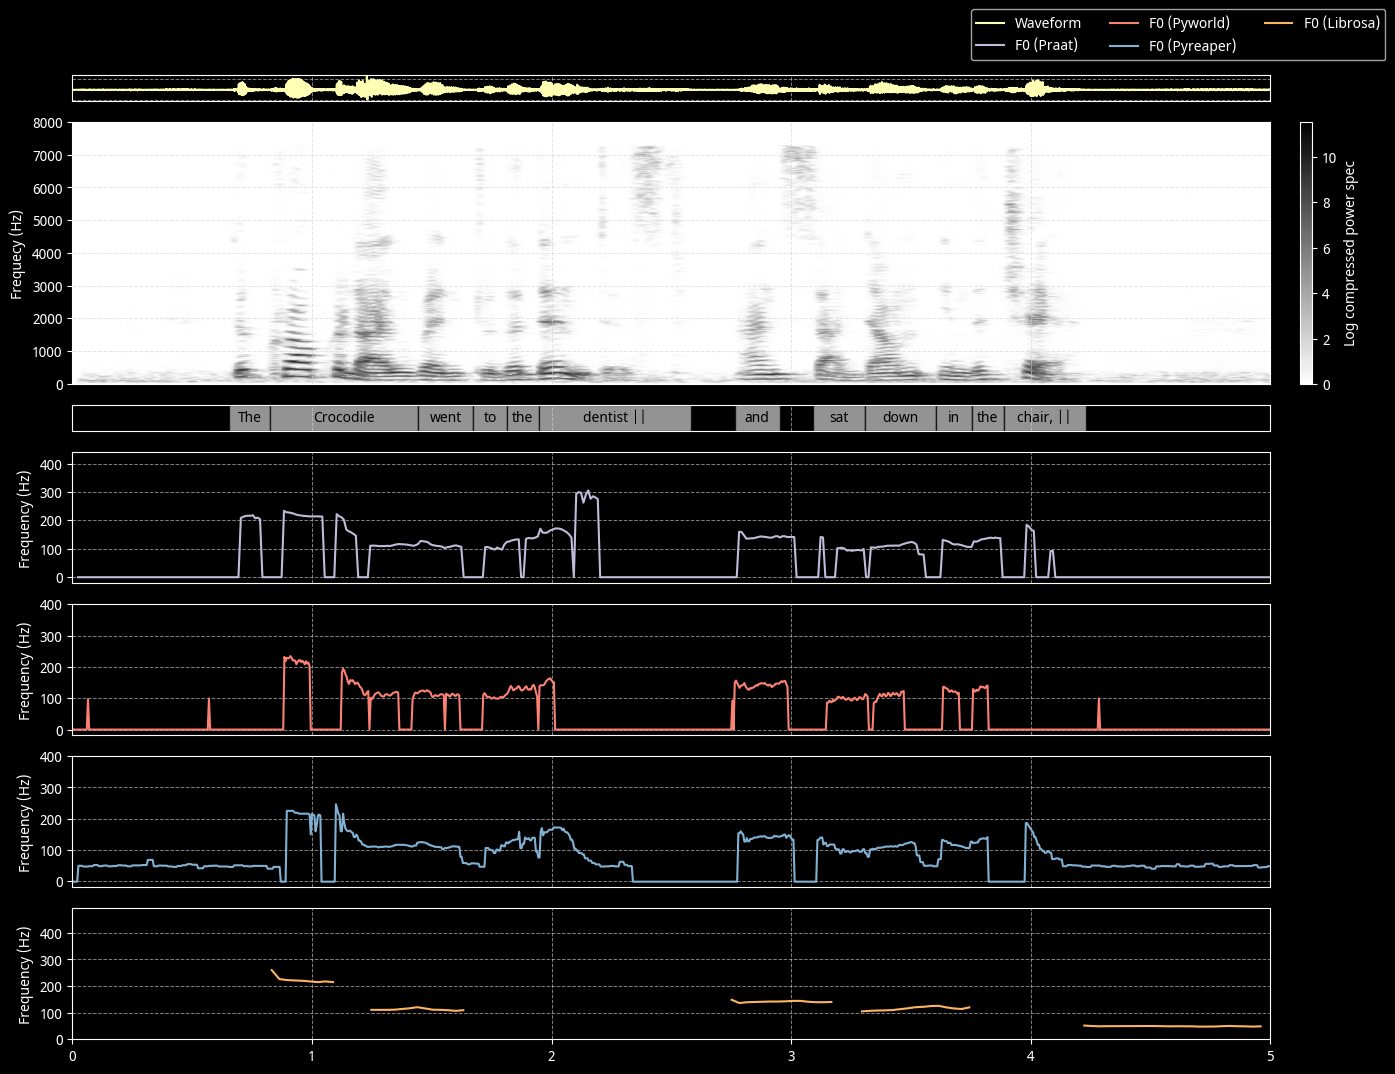

In [22]:
# Visualization
f0_yticks = np.arange(0, 401, 100)
fig = ms.fig("amassss", xlim=(0, 5), dark_mode=True)
fig.add_signal(y, np.arange(y.size) / sr, label="Waveform")
fig.add_matrix(S, S_f, S_t, o="lower", ylabel="Frequecy (Hz)", label="Log compressed power spec")
fig.add_annotation(ann)
fig.add_signal(f0_pm, t_pm, label="F0 (Praat)", ylabel="Frequency (Hz)", yticks=f0_yticks)
fig.add_signal(f0_pw, t_pw, label="F0 (Pyworld)", ylabel="Frequency (Hz)", yticks=f0_yticks)
fig.add_signal(f0_pr, t_pr, label="F0 (Pyreaper)", ylabel="Frequency (Hz)", yticks=f0_yticks)
fig.add_signal(f0_lb, t_lb, label="F0 (Librosa)", ylabel="Frequency (Hz)", yticks=f0_yticks)
fig.add_legend(0.92)

## Report

1. We 